In [841]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import talib as ta

In [842]:
activo = 'BTC-USD'
df = yf.Ticker(activo)
df = df.history(start='2022-01-01', end='2024-11-26')

In [843]:
# Cálculo del MACD
# df['MACD'], df['Signal_line'], df['Histogram'] = ta.MACD(df['Close'], fastperiod=12,
#                                                          slowperiod=26, signalperiod=9)

In [844]:
# Cálculo SMA200
df['SMA_50'] = df['Close'].rolling(window=40).mean()
df['SMA_200'] = df['Close'].rolling(window=60).mean()

In [845]:
# Crear columna para señales
df['Signal'] = 0
df.loc[df['SMA_50'] > df['SMA_200'], 'Signal'] = 1  # Compra
df.loc[df['SMA_50'] < df['SMA_200'], 'Signal'] = -1  # Vende
# # Señal de compra: tendencia alcista y MACD por encima de la señal
# df.loc[df['MACD'] > df['Signal_line'], 'Signal'] = 1

# # Señal de venta: tendencia bajista y MACD por debajo de la señal
# df.loc[df['MACD'] < df['Signal_line'], 'Signal'] = -1


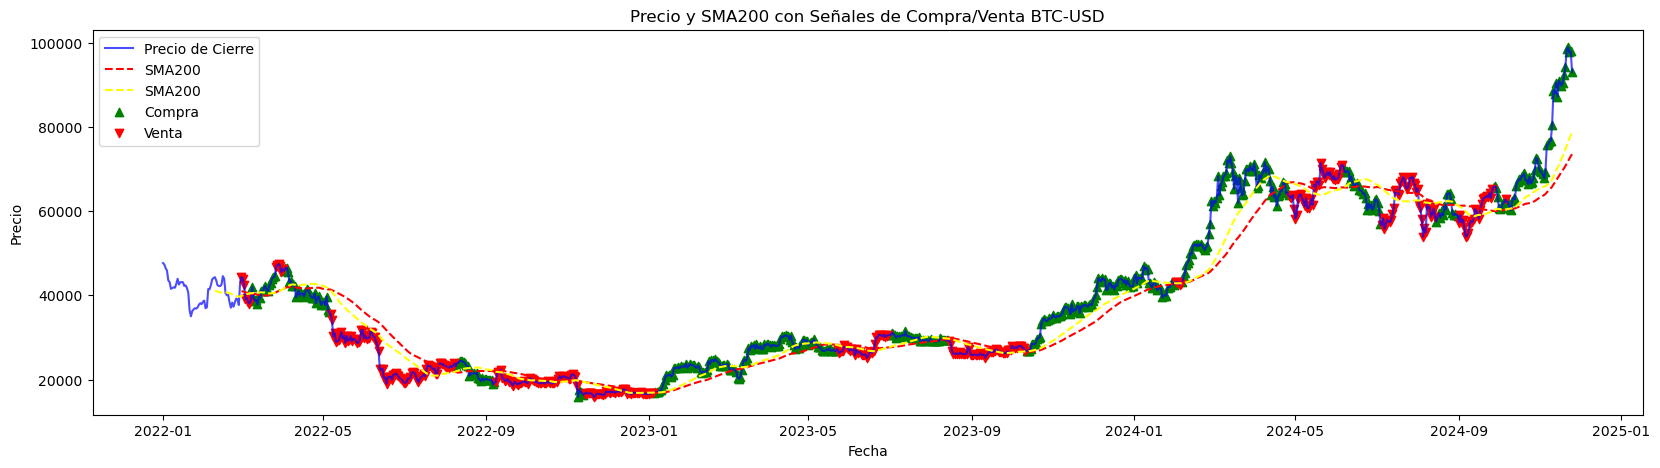

In [846]:
# Gráfico
plt.figure(figsize=(20,5))

plt.plot(df.index, df['Close'], label = 'Precio de Cierre', color='blue', alpha=0.7)
plt.plot(df.index, df['SMA_200'], label='SMA200', color='red', linestyle='--')
plt.plot(df.index, df['SMA_50'], label='SMA200', color='yellow', linestyle='--')
plt.scatter(df.index[df['Signal'] == 1], df['Close'][df['Signal'] == 1], marker='^', color='green', label='Compra', alpha=1)
plt.scatter(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1], marker='v', color='red', label='Venta', alpha=1)

plt.title(f'Precio y SMA200 con Señales de Compra/Venta {activo}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [847]:
# Simular ejecución de ordenes
df['Position'] = df['Signal'].shift()

In [848]:
# Definir comisiones y slippage
commission = 0.001  # 0.1% por operación
slippage = 0.0005  # 0.05% de slippage en cada operación

In [849]:
# Calcular los retornos de la estrategia con comisiones y slippage

df['Returns'] = df['Close'].pct_change() # Retornos daarios del activo
df['Strategy_Returns'] = df['Position'] * df['Returns']

In [850]:
# Aplicar comisiones y Slippage 
# (Ajusta los valores de comisiones y slippage según el broker)
df['Strategy_Returns'] -= (abs(df['Position'].diff()) * (commission + slippage))

In [851]:
# Eliminar NaNs
df.dropna(inplace=True)

In [852]:
# calcular rendimiento total y anualizado

# rendimiento anualizado
total_return = (df['Strategy_Returns'] + 1).prod() - 1
annualized_return = (1 + total_return) ** (252 / len(df)) - 1  # Ajustado por 252 días de trading anuales
print(f'Rendimiento Total: {total_return:.2%}')
print(f'Rendimiento Anualizado: {annualized_return:.2%}')

Rendimiento Total: 255.52%
Rendimiento Anualizado: 37.62%


In [853]:
# Ratio de Sharpe
risk_free_rate = 0.04
excess_return = df['Strategy_Returns'].mean() - (risk_free_rate / 252)
sharpe_ratio = excess_return / df['Strategy_Returns'].std()
print(f'Ratio de Sharpe: {sharpe_ratio:2f}')

Ratio de Sharpe: 0.053480


In [854]:
# Drawdown Máximo
df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()
df['Peak'] = df['Cumulative_Returns'].cummax()
df['Drawdown'] = (df['Cumulative_Returns'] - df['Peak']) / df['Peak']
max_drawdown = df['Drawdown'].min()
print(f'Máximo Drawdown: {max_drawdown:.2%}')

Máximo Drawdown: -55.87%


In [855]:
winning_trades = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].count()
lossing_trades = df[df['Strategy_Returns'] <= 0]['Strategy_Returns'].count()
win_loss_ratio = winning_trades / lossing_trades if lossing_trades != 0 else np.inf
ganancia_media = df[df['Strategy_Returns'] > 0]['Strategy_Returns'].mean()
perdida_media = df[df['Strategy_Returns'] <= 0]['Strategy_Returns'].mean()

print(f'Operaciones Ganadoras: {winning_trades} -- Ganancia Media: {ganancia_media:.2%}')
print(f'Operaciones Perdedoras: {lossing_trades} -- Pérdida Media: {perdida_media:.2%}')
print(f'Ratio Ganancias/Pérdidas: {win_loss_ratio:.2f}')


Operaciones Ganadoras: 512 -- Ganancia Media: 2.03%
Operaciones Perdedoras: 489 -- Pérdida Media: -1.79%
Ratio Ganancias/Pérdidas: 1.05


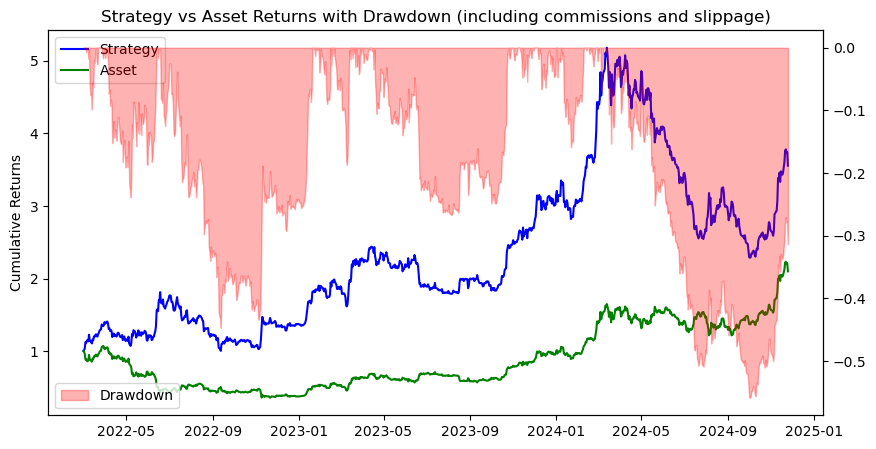

In [856]:
# Graficar el rendimiento de la estrategia frente al activo
fig, ax1 = plt.subplots(figsize=(10, 5))

# Graficar los rendimientos acumulados de la estrategia
ax1.plot(df.index, df['Cumulative_Returns'], label='Strategy', color='blue')

# Graficar los rendimientos acumulados del activo directamente usando Close
ax1.plot(df.index, (df['Close'] / df['Close'].iloc[0]), label='Asset', color='green')

ax1.set_ylabel('Cumulative Returns')

# Graficar el drawdown coloreado
ax2 = ax1.twinx()
ax2.fill_between(df.index, df['Drawdown'], 0 , color='red', alpha=0.3, label='Drawdown')

# Configurar leyendas y títulos
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.title('Strategy vs Asset Returns with Drawdown (including commissions and slippage)')

# Mostrar el gráfico
plt.show()

In [857]:
import numpy as np
import pandas as pd
# Ejemplo de ajuste de parámetros en Python
import yfinance as yf

In [858]:
activo = 'BTC-USD'
df = yf.Ticker(activo)
df = df.history(start='2022-01-01', end='2024-11-20')

In [859]:
def backtest_strategy(short_window, long_window):
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()
    df['Signal'] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
    df['Position'] = df['Signal'].shift()
    df['Strategy_Returns'] = df['Position'] * df['Close'].pct_change()
    return (df['Strategy_Returns'] + 1).cumprod().iloc[-1] -1 # Retorno total

In [860]:
short_windows = range(10, 100, 10) # De 10 a 90 días
long_windows = range(10, 200, 10) # De 50 a 190 días

In [861]:
best_performance = -np.inf
best_params = (None, None)

In [862]:
for short_window in short_windows:
    for long_window in long_windows:
        if short_window >= long_window:
            continue  # Evitar combinaciones donde la media corta sea mayor o igual a la larga
        performance = backtest_strategy(short_window, long_window)
        if performance > best_performance:
            best_performance = performance
            best_params = (short_window, long_window)

print(f"Mejores parámetros: SMA corta={best_params[0]}, SMA larga={best_params[1]}")
print(f"Mejor rendimiento: {best_performance:.2%}")

Mejores parámetros: SMA corta=40, SMA larga=60
Mejor rendimiento: 275.49%
